In [8]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(11)
%matplotlib inline

In [5]:
# Load the H2O library and start up the H2O cluster locally on your machine
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator


# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 23 hours 37 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,"28 days, 2 hours and 15 minutes"
H2O cluster name:,garrettfiddler
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [17]:
khous_df = pd.read_csv('khous_train.csv')

In [38]:
khous_df.shape

(1460, 81)

In [41]:
khous_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [57]:
khous_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [60]:
type(khous_df.dtypes[80])

numpy.dtype

In [43]:
khous_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [23]:
khous_h2 = h2o.H2OFrame(khous_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [19]:
khous_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [67]:
loss_by_type = {np.dtype('object'):"Categorical", 
                np.dtype('int64'):"Quadratic", 
                np.dtype('float64'):"Quadratic", 
                np.dtype('bool'):"Hinge"}
col_loss_types = [loss_by_type[obj_type] for obj_type in khous_df.dtypes]

In [85]:
glrmodel_2 = H2OGeneralizedLowRankEstimator(k=10, 
                                       max_iterations=100, 
                                       loss_by_col=col_loss_types, 
                                       impute_original=True)


In [86]:
glrmodel_2.train(y='SalePrice', training_frame=khous_h2)

glrm Model Build progress: |██████████████████████████████████████████████| 100%


In [88]:
glrmodel_2.proj_archetypes(khous_h2)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
684.644,43.2576,RL,87.9208,13948.1,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8.36364,5.22727,1998.84,2002.44,Hip,CompShg,VinylSd,VinylSd,BrkFace,388.763,Gd,TA,PConc,Ex,TA,No,GLQ,931.371,Unf,13.197,720.811,1665.38,GasA,Ex,Y,SBrkr,1688.18,638.598,-5.32907e-15,2326.78,0.727273,0.0151515,2.09848,0.636364,3.13636,1,Gd,8.56061,Typ,1.18182,Gd,Attchd,2001.11,Fin,2.82576,785.848,TA,TA,Y,200.25,88.3636,8.06061,3.57576,20.2576,4.20455,nan,nan,nan,-4.26326e-14,6.68939,2007.77,WD,Normal,353526
760.081,112.5,RL,69.4887,9839.87,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,Duplex,1Story,4.87097,5.1129,1946.24,1968.69,Gable,CompShg,MetalSd,MetalSd,None,75.1078,TA,TA,CBlock,TA,TA,No,Unf,231.129,Unf,16.9677,645.839,893.935,GasA,TA,Y,SBrkr,1296.27,462.887,0,1759.16,0.225806,0.0483871,2,0.177419,3.79032,2.03226,TA,8.45161,Typ,0.225806,nan,Detchd,1966.05,Unf,1.54839,404.613,TA,TA,Y,36.0161,21.9032,34.2581,-4.44089e-16,1.59677,4.44089e-16,nan,nan,nan,198.387,6.75806,2007.92,WD,Normal,127865
753.224,46.0959,RL,78.2945,13214.4,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5.91324,5.78995,1963.04,1976.4,Gable,CompShg,Plywood,Plywood,None,126.224,TA,TA,CBlock,TA,TA,No,ALQ,590.265,Unf,135.694,442.895,1168.85,GasA,TA,Y,SBrkr,1354.78,281.982,0.242009,1637,0.515982,0.127854,1.49772,0.47032,3.05023,1.00457,TA,6.6758,Typ,1.23744,TA,Attchd,1965.66,RFn,1.85388,491.877,TA,TA,Y,108.735,53.9817,21.0639,1.77169,58.2055,11.3288,nan,nan,nan,50.2283,6.45662,2007.84,WD,Normal,183473
722.888,76.9502,RL,68.216,9771.78,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6.81328,5.20332,1996.98,1998.82,Gable,CompShg,VinylSd,VinylSd,None,88.0625,Gd,TA,PConc,Gd,TA,No,Unf,300.577,Unf,12.4772,546.896,859.95,GasA,Ex,Y,SBrkr,919.776,855.643,0.995851,1776.41,0.302905,0.0248963,2.01245,0.950207,3.12033,1,Gd,7.19087,Typ,0.676349,TA,Attchd,1997.3,Fin,2.07884,521.506,TA,TA,Y,103.535,68.5145,6.05394,3.51452,3.24066,-7.99361e-15,nan,nan,nan,12.3651,6.06224,2007.76,WD,Normal,202017
593.588,68.2353,RL,79.1206,10902.7,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5.82353,5.64706,1920.76,1973.71,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,197.059,Unf,79.1176,676.647,952.824,GasA,Ex,Y,SBrkr,1151.06,629.059,432.588,2212.71,0.235294,0.0588235,1.58824,0.235294,3.76471,1.05882,TA,8.58824,Typ,0.529412,nan,Detchd,1972.3,Unf,1.17647,359.412,TA,TA,Y,76.4706,55.0588,59.2941,-4.44089e-16,24.1176,30.1176,nan,nan,nan,23.5294,5.82353,2007.59,WD,Normal,164735
1299,60,RL,313,63887,Pave,nan,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008,Fin,2,1418,TA,TA,Y,214,292,0,0,-1.77636e-15,480,Gd,nan,nan,0,1,2008,New,Partial,160000
401.75,70,RL,90.0375,163514,Pave,nan,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6.25,5.75,1964.75,1984.5,Gable,CompShg,Plywood,Plywood,None,205.75,TA,TA,CBlock,Gd,TA,Gd,ALQ,1100.25,Unf,241.75,338.5,1680.5,GasA,TA,Y,SBrkr,1730.75,216.75,0,1947.5,1.25,0.25,2,0,3,1,Gd,6.

               timestamp    duration  iterations  step_size     objective
0    2018-06-28 15:40:25   0.508 sec         0.0   0.666667  1.026142e+13
1    2018-06-28 15:40:25   0.730 sec         1.0   0.444444  1.026142e+13
2    2018-06-28 15:40:25   0.884 sec         2.0   0.222222  1.026142e+13
3    2018-06-28 15:40:25   1.013 sec         3.0   0.074074  1.026142e+13
4    2018-06-28 15:40:25   1.194 sec         4.0   0.018519  1.026142e+13
5    2018-06-28 15:40:25   1.337 sec         5.0   0.003704  1.026142e+13
6    2018-06-28 15:40:26   1.486 sec         6.0   0.000617  1.026142e+13
7    2018-06-28 15:40:26   1.632 sec         7.0   0.000088  1.026142e+13


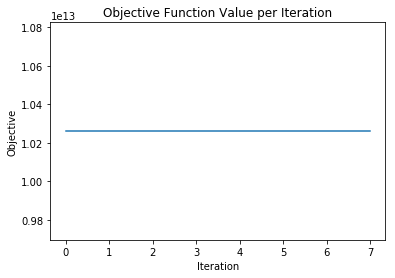

In [90]:
# Plot objective function value each iteration
model_score = glrmodel_2.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
print(model_score)
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

### GLRM first attempt (default settings)

In [ ]:
glrm = H2OGeneralizedLowRankEstimator(k=30, max_iterations=100)

In [25]:
glrm.train(y='SalePrice', training_frame=khous_h2)

glrm Model Build progress: |██████████████████████████████████████████████| 100%


In [30]:
glrm.proj_archetypes(khous_h2)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
708.328,25.8621,RL,86.1759,12303.3,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8.34483,5.05172,2002.5,2003.76,Hip,CompShg,VinylSd,VinylSd,Stone,298.857,Gd,TA,PConc,Ex,TA,Gd,GLQ,1292.12,Unf,41.2069,508.534,1841.86,GasA,Ex,Y,SBrkr,1836.07,9.5,8.88178e-16,1845.57,1,-3.46945e-17,1.93103,0.206897,2.55172,1,Gd,7.36207,Typ,1.13793,Gd,Attchd,2002.62,Fin,2.7069,755.862,TA,TA,Y,171.069,80.0517,11.7586,-8.88178e-16,16.3793,4.44089e-16,nan,nan,nan,34.4828,6.51724,2008.03,WD,Normal,325412
738.594,157.812,RM,30.9109,2817.41,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,5.46875,5.4375,1973.28,1975.56,Gable,CompShg,HdBoard,HdBoard,BrkFace,161.062,TA,TA,CBlock,TA,TA,No,ALQ,269.375,Unf,40.3125,317.906,627.594,GasA,TA,Y,SBrkr,651.719,571.281,8.88178e-16,1223,0.15625,0.03125,1.28125,0.96875,2.75,1,TA,5.84375,Typ,0.34375,nan,Attchd,1974.94,Unf,1.25,317.969,TA,TA,Y,74.2812,10.5625,-3.55271e-15,-8.88178e-16,-1.77636e-15,4.44089e-16,nan,nan,nan,14.0625,5.53125,2008.22,WD,Normal,113395
873,85,RL,80.125,10211.1,Pave,nan,Reg,Bnk,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,2.5Fin,5.875,5.875,1917.12,1979.62,Gable,CompShg,Wd Sdng,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,LwQ,196,Unf,58.625,670.875,925.5,GasA,Ex,Y,SBrkr,1257.38,977,406.5,2640.88,0.25,0,1.875,0.25,4.625,1.125,TA,10.375,Typ,0.625,nan,nan,1976.63,nan,0.75,253,TA,nan,Y,118.875,79.625,6.25,0,-1.77636e-15,0,nan,nan,nan,0,6.5,2007.75,WD,Normal,164062
654.096,30.137,RL,82.7719,14984.4,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5.87671,5.50685,1966.97,1977.23,Gable,CompShg,Plywood,Plywood,BrkFace,145.932,TA,TA,CBlock,TA,TA,No,ALQ,621.781,Unf,149.096,577.37,1348.25,GasA,TA,Y,SBrkr,1563.51,8.94521,-1.77636e-15,1572.45,0.630137,-4.85723e-17,1.57534,0.260274,2.87671,1,TA,6.45205,Typ,1.38356,TA,Attchd,1968.59,RFn,1.86301,508.986,TA,TA,Y,95.274,40.4658,31.8082,-8.88178e-16,6.82192,8.88178e-16,nan,nan,nan,9.58904,6.0137,2008.12,WD,Normal,178620
739.869,61.0656,RL,75.9492,11595.9,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,6.11475,6,1962.69,1977.18,Gable,CompShg,HdBoard,HdBoard,BrkFace,166.885,TA,TA,CBlock,TA,TA,No,ALQ,419.623,Unf,75.3934,343.721,838.738,GasA,TA,Y,SBrkr,1111.66,814.361,0.868852,1926.89,0.213115,0.0491803,1.72131,0.868852,3.52459,1,TA,7.65574,Typ,1.04918,TA,Attchd,1966.07,Unf,1.91803,485.049,TA,TA,Y,112.754,77.2623,19.6885,-8.88178e-16,10.9508,4.44089e-16,nan,nan,nan,20.4918,7.14754,2007.36,WD,Normal,189560
787.937,161.875,FV,36.8203,3025.34,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6.6875,5,2002.88,2003.22,Gable,CompShg,MetalSd,MetalSd,BrkFace,184.031,Gd,TA,PConc,Gd,TA,No,GLQ,270.719,Unf,-7.10543e-15,442.062,712.781,GasA,Ex,Y,SBrkr,758.031,638.094,7.5,1403.62,0.28125,0,1.9375,0.71875,2.375,1,Gd,5.28125,Typ,0.09375,nan,Detchd,2002.88,Unf,2,475.625,TA,TA,Y,14.8125,63.9062,-3.55271e-15,-4.44089e-16,-1.77636e-15,4.44089e-16,nan,nan,nan,-1.42109e-14,5.46875,2007.53,WD,Normal,158984
739.291,36.511,RL,70.181,9502.98,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5.11538,6.15934,1963.81,1978.36,Gable,CompShg,HdBoard,HdBoard,None,41.2912,TA,TA,CBlock,

In [ ]:
glrm.archetypes()[1]

Jason thought he remembered 'categorical' getting parsed differently from 'enum', hence the little loop below which changes all the dtypes to 'categorical'.  So I might want want to try a similar thing with just my enums and see what changes.

In [ ]:
types = {} 
for k in region_a_df.types: 
    types[k] = 'categorical' 
    types['C1'] = 'string' 
region_a_df = h2o.H2OFrame(np.array(region_answers)[:,1:], column_types=types) region_a_df.describe()

glrm.train(y=y, training_frame=region_a_df)

In [36]:
khous_h2.types

{'1stFlrSF': 'int',
 '2ndFlrSF': 'int',
 '3SsnPorch': 'int',
 'Alley': 'enum',
 'BedroomAbvGr': 'int',
 'BldgType': 'enum',
 'BsmtCond': 'enum',
 'BsmtExposure': 'enum',
 'BsmtFinSF1': 'int',
 'BsmtFinSF2': 'int',
 'BsmtFinType1': 'enum',
 'BsmtFinType2': 'enum',
 'BsmtFullBath': 'int',
 'BsmtHalfBath': 'int',
 'BsmtQual': 'enum',
 'BsmtUnfSF': 'int',
 'CentralAir': 'enum',
 'Condition1': 'enum',
 'Condition2': 'enum',
 'Electrical': 'enum',
 'EnclosedPorch': 'int',
 'ExterCond': 'enum',
 'ExterQual': 'enum',
 'Exterior1st': 'enum',
 'Exterior2nd': 'enum',
 'Fence': 'enum',
 'FireplaceQu': 'enum',
 'Fireplaces': 'int',
 'Foundation': 'enum',
 'FullBath': 'int',
 'Functional': 'enum',
 'GarageArea': 'int',
 'GarageCars': 'int',
 'GarageCond': 'enum',
 'GarageFinish': 'enum',
 'GarageQual': 'enum',
 'GarageType': 'enum',
 'GarageYrBlt': 'int',
 'GrLivArea': 'int',
 'HalfBath': 'int',
 'Heating': 'enum',
 'HeatingQC': 'enum',
 'HouseStyle': 'enum',
 'Id': 'int',
 'KitchenAbvGr': 'int',
 '